In [1]:
!git clone https://github.com/rkuo2000/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12560, done.
remote: Total 12560 (delta 0), reused 0 (delta 0), pack-reused 12560
Receiving objects: 100% (12560/12560), 12.29 MiB | 8.56 MiB/s, done.
Resolving deltas: 100% (8621/8621), done.
/content/yolov5


In [2]:
!echo "train: Dataset/train/images" > data/alpr.yaml
!echo "val:   Dataset/train/images" >> data/alpr.yaml

!echo "nc : 1" >> data/alpr.yaml
!echo "names: ['license']" >> data/alpr.yaml

!cat data/alpr.yaml

train: Dataset/train/images
val:   Dataset/train/images
nc : 1
names: ['license']


In [3]:
!pip install -r requirements.txt -q

     |████████████████████████████████| 1.6 MB 43.7 MB/s 


In [4]:
!unzip /content/drive/MyDrive/datasets/car_plate/archive.zip -d /content/dataset

Archive:  /content/drive/MyDrive/datasets/car_plate/archive.zip
  inflating: /content/dataset/annotations/Cars0.xml  
  inflating: /content/dataset/annotations/Cars1.xml  
  inflating: /content/dataset/annotations/Cars10.xml  
  inflating: /content/dataset/annotations/Cars100.xml  
  inflating: /content/dataset/annotations/Cars101.xml  
  inflating: /content/dataset/annotations/Cars102.xml  
  inflating: /content/dataset/annotations/Cars103.xml  
  inflating: /content/dataset/annotations/Cars104.xml  
  inflating: /content/dataset/annotations/Cars105.xml  
  inflating: /content/dataset/annotations/Cars106.xml  
  inflating: /content/dataset/annotations/Cars107.xml  
  inflating: /content/dataset/annotations/Cars108.xml  
  inflating: /content/dataset/annotations/Cars109.xml  
  inflating: /content/dataset/annotations/Cars11.xml  
  inflating: /content/dataset/annotations/Cars110.xml  
  inflating: /content/dataset/annotations/Cars111.xml  
  inflating: /content/dataset/annotations/Cars

In [5]:
import os
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile

In [6]:
FILE_ROOT = "/content/dataset/"
IMAGE_PATH = FILE_ROOT + "images"  
ANNOTATIONS_PATH = FILE_ROOT + "annotations"

DATA_ROOT = "Dataset/"
DEST_IMAGES_PATH = "train/images"
DEST_LABELS_PATH = "train/labels"

In [7]:
!mkdir -p Dataset/train/labels

In [8]:
# copy images
!mkdir -p Dataset/train
!cp -rf /content/dataset/images Dataset/train

In [9]:
!mkdir -p Dataset/val
!cp -rf /content/dataset/images/Cars1*.png Dataset/val

In [10]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]
    
def save_file(img_jpg_file_name, size, img_box):
    classes = ['license']
    save_file_name = DATA_ROOT + DEST_LABELS_PATH + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:                  
        #cls_num = classes.index(box[0]) # find class_id
        cls_num = 0
        new_box = cord_converter(size, box[1:]) # convert box coord into YOLO x,y,w,h

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)
    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [11]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

file name:  Cars409.xml
/content/dataset/annotations/Cars409.xml
box:(c,xmin,ymin,xmax,ymax) licence 116 146 203 168
Dataset/train/labels/Cars409.txt
file name:  Cars46.xml
/content/dataset/annotations/Cars46.xml
box:(c,xmin,ymin,xmax,ymax) licence 189 193 352 248
Dataset/train/labels/Cars46.txt
file name:  Cars347.xml
/content/dataset/annotations/Cars347.xml
box:(c,xmin,ymin,xmax,ymax) licence 227 124 252 135
Dataset/train/labels/Cars347.txt
file name:  Cars278.xml
/content/dataset/annotations/Cars278.xml
box:(c,xmin,ymin,xmax,ymax) licence 278 138 315 163
Dataset/train/labels/Cars278.txt
file name:  Cars298.xml
/content/dataset/annotations/Cars298.xml
box:(c,xmin,ymin,xmax,ymax) licence 166 148 233 184
Dataset/train/labels/Cars298.txt
file name:  Cars291.xml
/content/dataset/annotations/Cars291.xml
box:(c,xmin,ymin,xmax,ymax) licence 71 205 215 246
Dataset/train/labels/Cars291.txt
file name:  Cars268.xml
/content/dataset/annotations/Cars268.xml
box:(c,xmin,ymin,xmax,ymax) licence 213

In [12]:
!mkdir -p Dataset/val/labels
!cp -rf Dataset/train/labels/Cars1*.txt Dataset/val/labels

In [13]:
!ls Dataset/train/labels

Cars0.txt    Cars166.txt  Cars231.txt  Cars298.txt  Cars363.txt  Cars429.txt
Cars100.txt  Cars167.txt  Cars232.txt  Cars299.txt  Cars364.txt  Cars42.txt
Cars101.txt  Cars168.txt  Cars233.txt  Cars29.txt   Cars365.txt  Cars430.txt
Cars102.txt  Cars169.txt  Cars234.txt  Cars2.txt    Cars366.txt  Cars431.txt
Cars103.txt  Cars16.txt   Cars235.txt  Cars300.txt  Cars367.txt  Cars432.txt
Cars104.txt  Cars170.txt  Cars236.txt  Cars301.txt  Cars368.txt  Cars43.txt
Cars105.txt  Cars171.txt  Cars237.txt  Cars302.txt  Cars369.txt  Cars44.txt
Cars106.txt  Cars172.txt  Cars238.txt  Cars303.txt  Cars36.txt	 Cars45.txt
Cars107.txt  Cars173.txt  Cars239.txt  Cars304.txt  Cars370.txt  Cars46.txt
Cars108.txt  Cars174.txt  Cars23.txt   Cars305.txt  Cars371.txt  Cars47.txt
Cars109.txt  Cars175.txt  Cars240.txt  Cars306.txt  Cars372.txt  Cars48.txt
Cars10.txt   Cars176.txt  Cars241.txt  Cars307.txt  Cars373.txt  Cars49.txt
Cars110.txt  Cars177.txt  Cars242.txt  Cars308.txt  Cars374.txt  Cars4.txt
Cars111.tx

In [14]:
!python train.py --img 416 --batch 16 --epochs 100 --data data/alpr.yaml --cfg models/yolov5s.yaml

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/alpr.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/rkuo2000/yolov5 ✅
YOLOv5 🚀 v6.1-303-gb3ca8d8 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hs

In [15]:
# Download OpenALPR Benchmarks
%cd ..
!git clone https://github.com/openalpr/benchmarks

/content
Cloning into 'benchmarks'...
remote: Enumerating objects: 1752, done.
remote: Total 1752 (delta 0), reused 0 (delta 0), pack-reused 1752
Receiving objects: 100% (1752/1752), 187.98 MiB | 16.73 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [16]:
%cd yolov5

/content/yolov5


In [17]:
!python detect.py --source ../benchmarks/endtoend/us --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

detect: weights=['runs/train/exp/weights/best.pt'], source=../benchmarks/endtoend/us, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-303-gb3ca8d8 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/222 /content/benchmarks/endtoend/us/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg: 384x640 1 license, Done. (0.013s)
image 2/222 /content/benchmarks/endtoend/us/12c6cb72-3ea3-49e7-b381-e0cdfc5e8960.jpg: 384x640 Done. (0.009s)
image 3/222 /content/benchmarks/endtoend/us/1e241dc8-8f18-4955-8988-03a0ab49f813.jpg: 384x640 1 license, Done. (0.009s)
image

In [18]:
!python detect.py --source ../benchmarks/endtoend/eu --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

detect: weights=['runs/train/exp/weights/best.pt'], source=../benchmarks/endtoend/eu, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-303-gb3ca8d8 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/108 /content/benchmarks/endtoend/eu/eu1.jpg: 480x640 1 license, Done. (0.011s)
image 2/108 /content/benchmarks/endtoend/eu/eu10.jpg: 544x640 2 licenses, Done. (0.013s)
image 3/108 /content/benchmarks/endtoend/eu/eu11.jpg: 416x640 1 license, Done. (0.013s)
image 4/108 /content/benchmarks/endtoend/eu/eu2.jpg: 480x640 1 license, Done. (0.010s)
ima

In [19]:
!python detect.py --source ../benchmarks/endtoend/br --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

detect: weights=['runs/train/exp/weights/best.pt'], source=../benchmarks/endtoend/br, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-303-gb3ca8d8 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/115 /content/benchmarks/endtoend/br/AYO9034.jpg: 384x640 1 license, Done. (0.013s)
image 2/115 /content/benchmarks/endtoend/br/AZJ6991.jpg: 640x640 1 license, Done. (0.013s)
image 3/115 /content/benchmarks/endtoend/br/FZB9581.jpg: 640x640 1 license, Done. (0.013s)
image 4/115 /content/benchmarks/endtoend/br/GWT2180.jpg: 384x640 1 license, Done.

In [25]:
!python detect.py --source /content/dataset/images --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/dataset/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-303-gb3ca8d8 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/433 /content/dataset/images/Cars0.png: 352x640 1 license, Done. (0.012s)
image 2/433 /content/dataset/images/Cars1.png: 416x640 1 license, Done. (0.012s)
image 3/433 /content/dataset/images/Cars10.png: 384x640 1 license, Done. (0.012s)
image 4/433 /content/dataset/images/Cars100.png: 448x640 1 license, Done. (0.011s)
image 5/433 /content/dataset/

In [26]:
!zip -r /content/detected_images.zip /content/yolov5/runs/detect/exp4

  adding: content/yolov5/runs/detect/exp4/ (stored 0%)
  adding: content/yolov5/runs/detect/exp4/Cars428.png (deflated 1%)
  adding: content/yolov5/runs/detect/exp4/Cars104.png (deflated 1%)
  adding: content/yolov5/runs/detect/exp4/Cars285.png (deflated 1%)
  adding: content/yolov5/runs/detect/exp4/Cars366.png (deflated 6%)
  adding: content/yolov5/runs/detect/exp4/Cars219.png (deflated 11%)
  adding: content/yolov5/runs/detect/exp4/Cars206.png (deflated 2%)
  adding: content/yolov5/runs/detect/exp4/Cars63.png (deflated 1%)
  adding: content/yolov5/runs/detect/exp4/Cars182.png (deflated 1%)
  adding: content/yolov5/runs/detect/exp4/Cars64.png (deflated 2%)
  adding: content/yolov5/runs/detect/exp4/Cars246.png (deflated 2%)
  adding: content/yolov5/runs/detect/exp4/Cars380.png (deflated 1%)
  adding: content/yolov5/runs/detect/exp4/Cars151.png (deflated 1%)
  adding: content/yolov5/runs/detect/exp4/Cars240.png (deflated 2%)
  adding: content/yolov5/runs/detect/exp4/Cars204.png (deflate

In [27]:
from google.colab import files
files.download("/content/detected_images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Detect

In [20]:
from IPython.display import Image

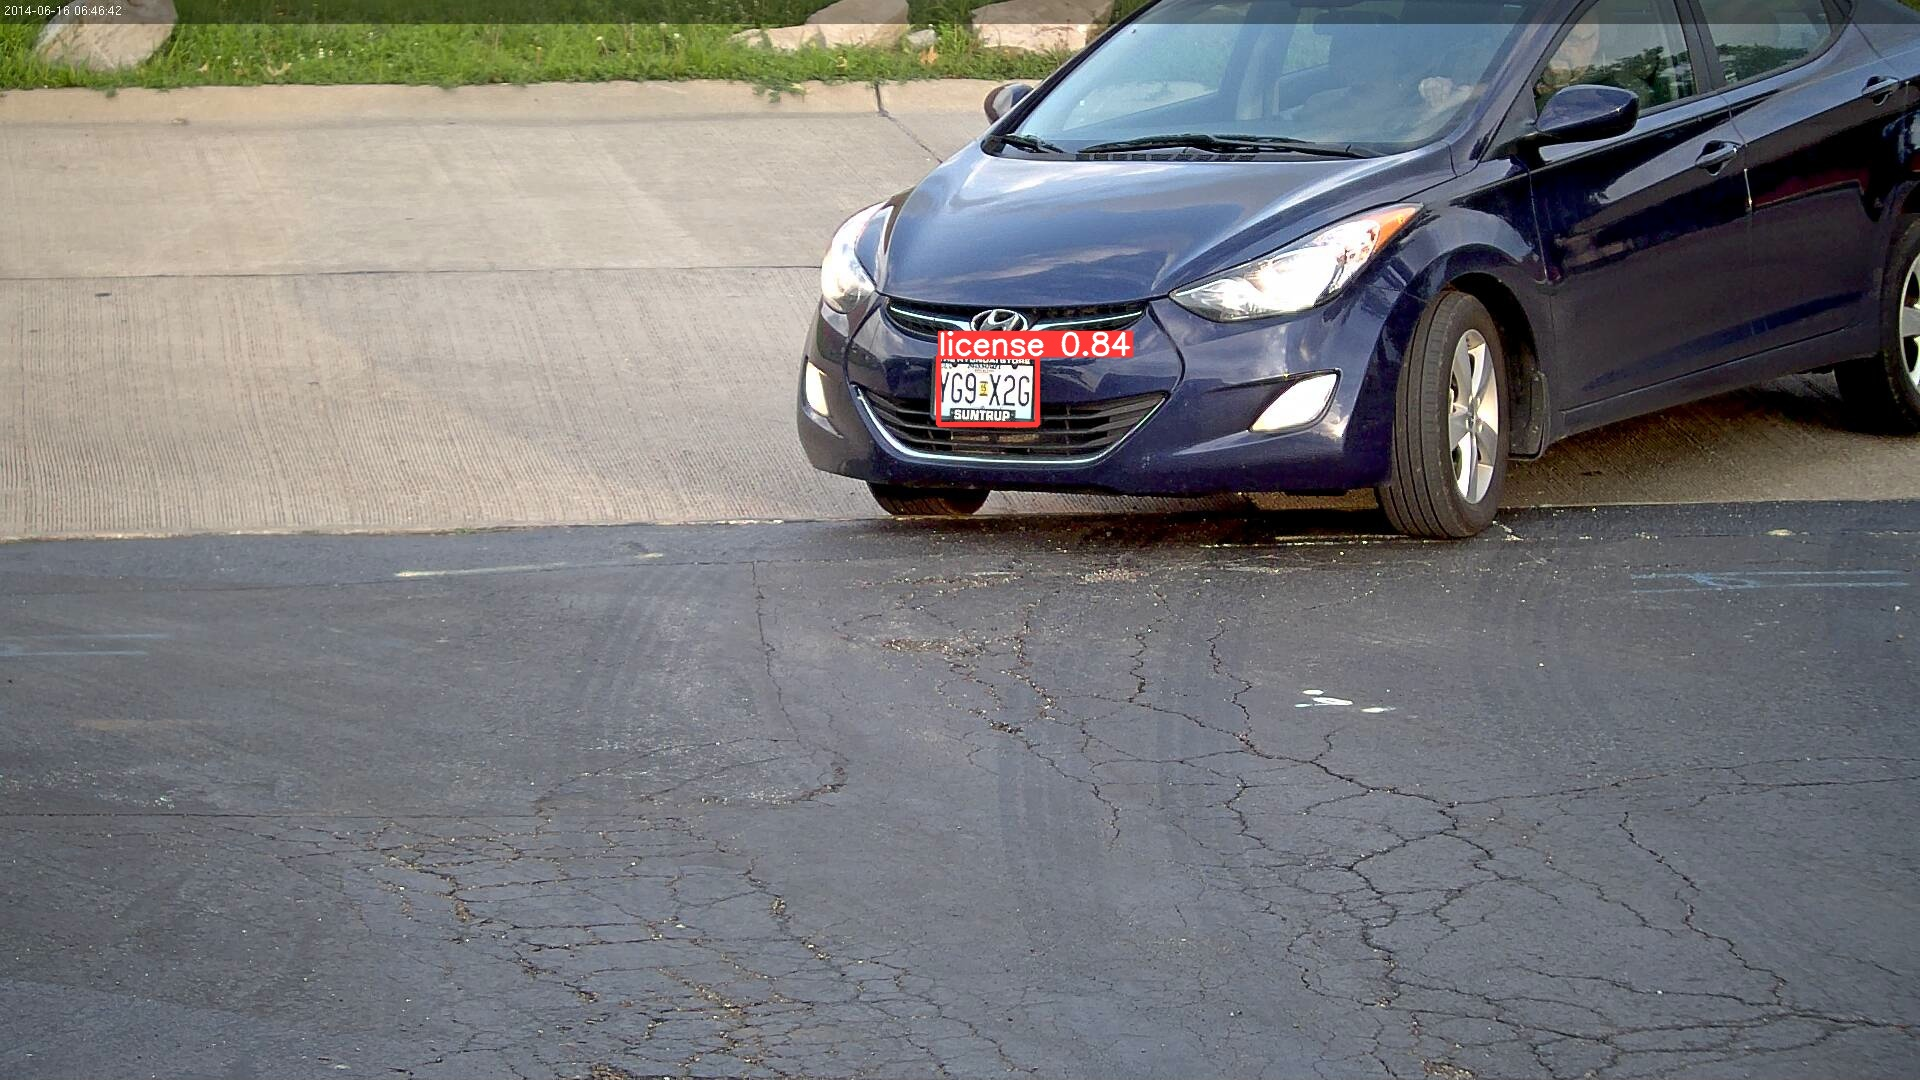

In [21]:
Image('runs/detect/exp/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg')

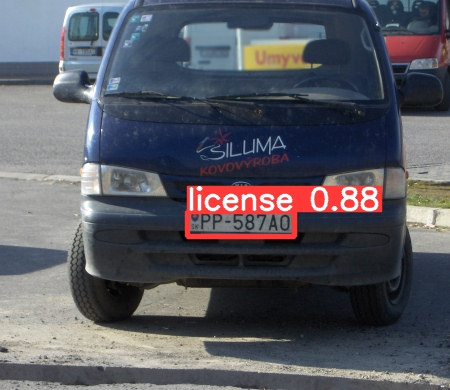

In [22]:
Image('runs/detect/exp2/test_001.jpg')

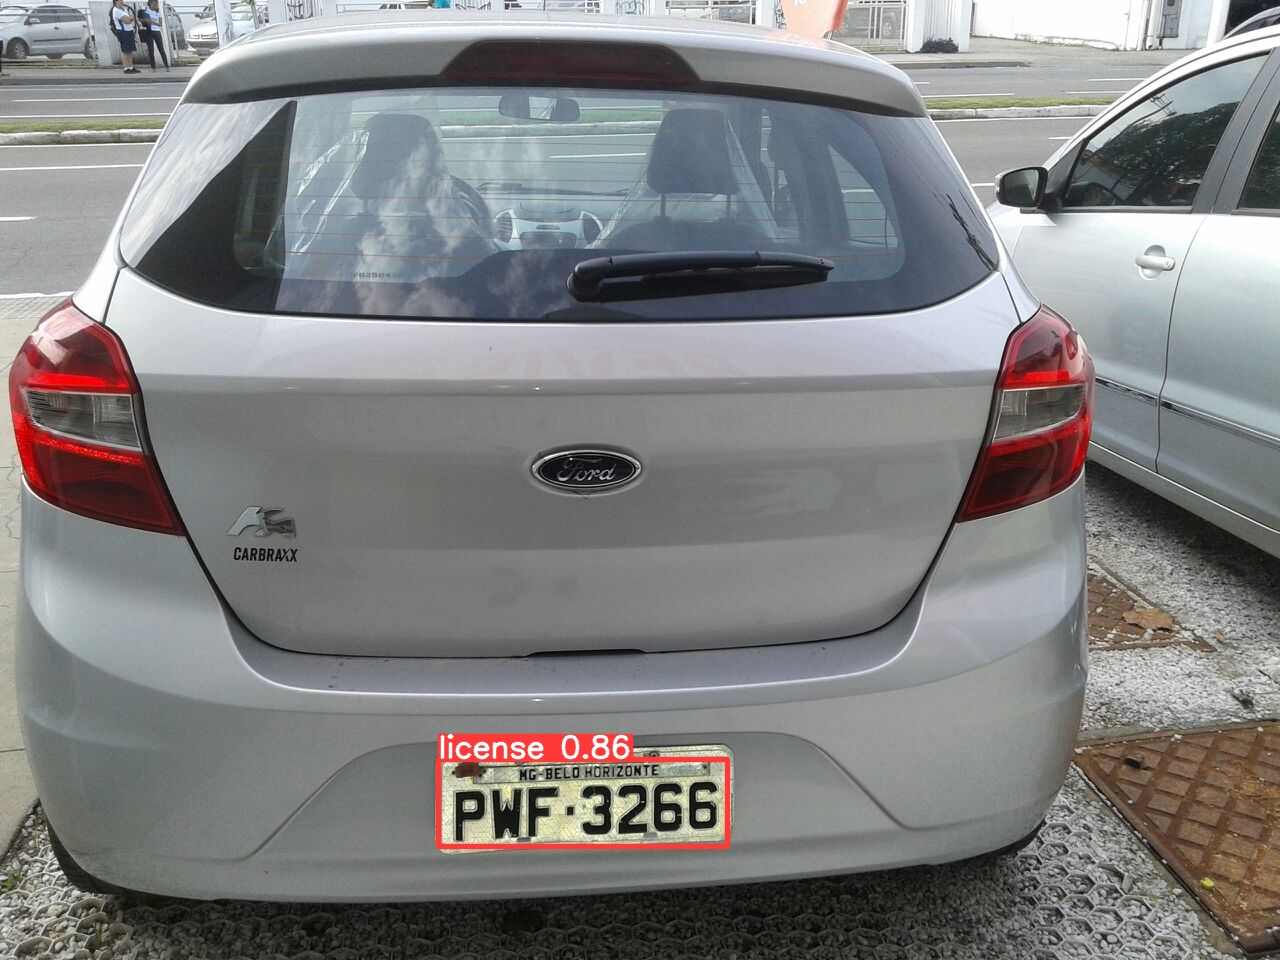

In [23]:
Image('runs/detect/exp3/PWF3266.jpg')

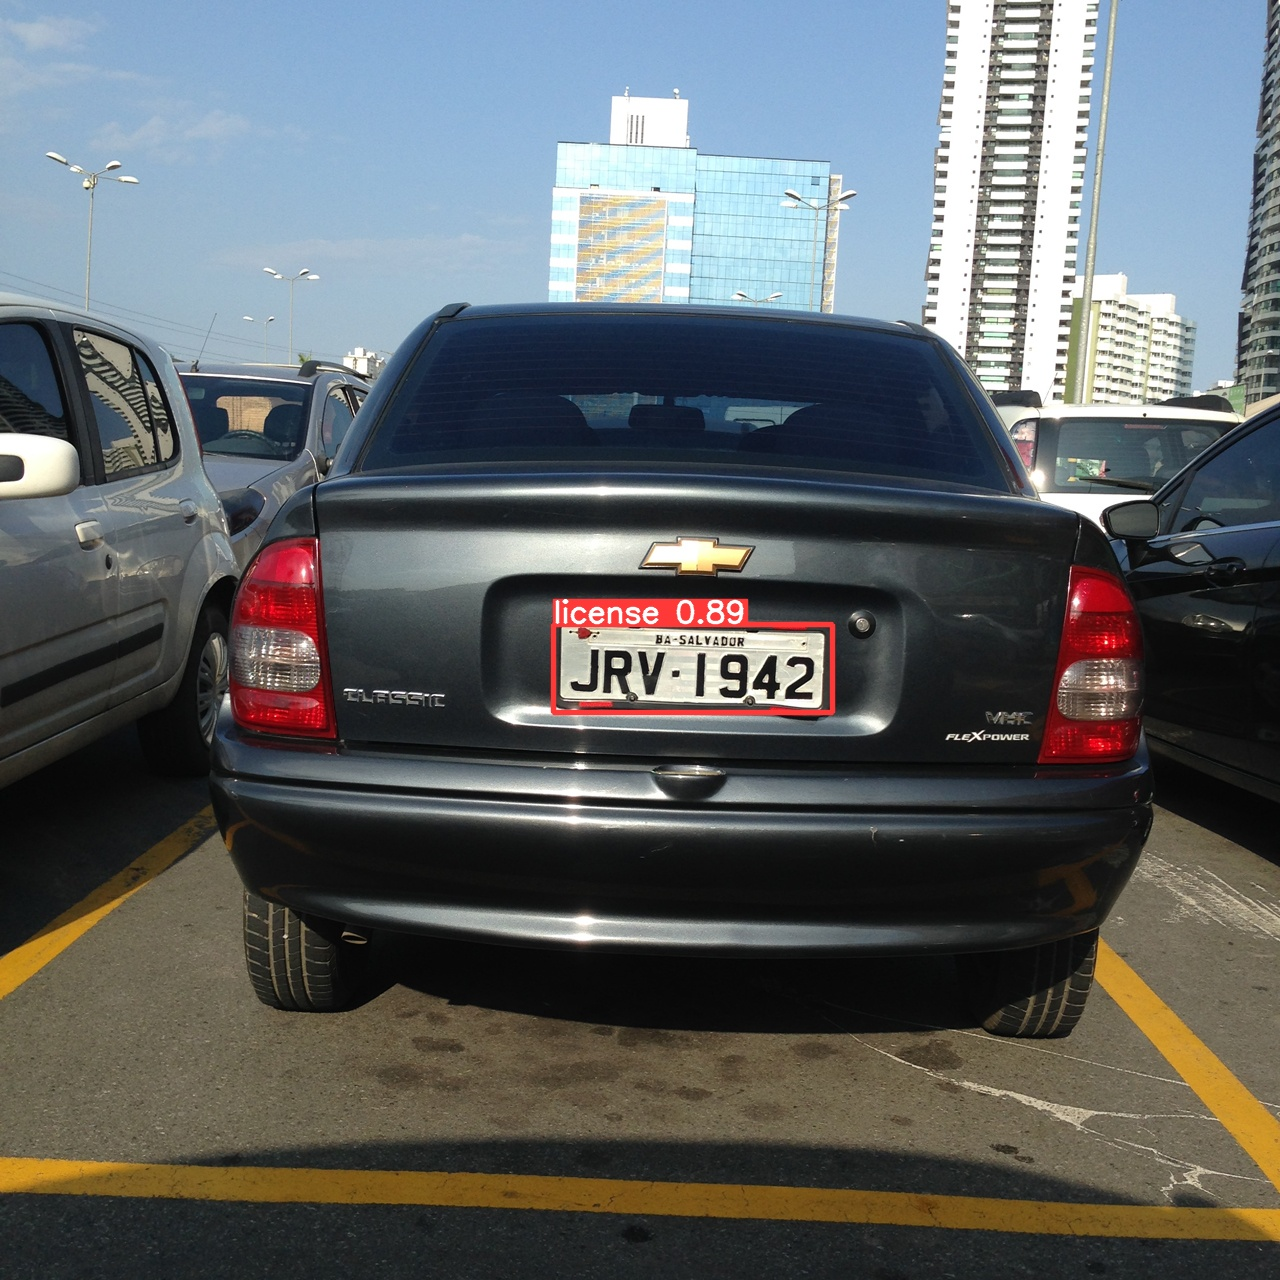

In [24]:
Image('/content/yolov5/runs/detect/exp3/JRV1942.jpg')